# Project Report
### Jason Cai, Kaiwen Hu, Bao Nguyen, Shantelle Virginillo

## Introduction

#### Background Information
A computer science research team led by Frank Wood is currently collecting data about how people play video games, specifically Minecraft. To do this, they set up a Minecraft server and meticulously record player actions and data, including their age, experience level, hours of play, whether the player is subscribed, and more. In general, there are three board questions the team is hoping to answer:

1. What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

2. We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

3. We are interested in demand forecasting, namely, what time windows are most likely to have a large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. 


#### Specific Question:

Can a KNN-Regression model use the variables experience, age, subscribe, and gender to predict played_hours in players.csv such that the RMSPE is no larger than 1.3 times the RMSE?

#### Dataset Description

##### The "Players" dataset contains 7 variables and 196 observations:
 
- __experience__ *(Character)*: How experienced the player is
- __hashedEmail__ *(Character)*: The player's email hashed
- __name__ *(Character)*: The name of the player
- __gender__ *(Character)*: The gender of the player
- __played_hours__ *(Double)*: How many hours the player played
- __Age__ *(Double)*: The age of the player
- __subscribe__ *(logical)*: If the player is subscribed


## Methods


In [1]:
# Loading in the Libraries
library(tidyverse)
library(cowplot)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1234)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ──────────────────────

#### Loading Data: 

First, we started with loading our data. We loaded our data from the url "https://raw.githubusercontent.com/JasonCai0522/DSCI100_Datasets/refs/heads/main/players.csv" to ensure that ohers can run our notebook even without the dataset downloaded on their device.


In [2]:
# Loading in the data
player_data <- read_csv("https://raw.githubusercontent.com/JasonCai0522/DSCI100_Datasets/refs/heads/main/players.csv", show_col_types = FALSE)

#### Wrangling and Cleaning Data: 

To clean the data, we first decided to change the variables __experience__, and __gender__ from *character* type to *factor* type to more accurately reflect the data being represented. We also decided to drop all columns where the age is na to prevent issues in our model. Afterwards, we decided to select only the columns that were prevalent to our focus question (__experience__, __gender__, and __subscribe__, __played_hours__, __age__) to cut out unnecessary info in our dataframe.

In [3]:
# Changing data types
player_data_factor <- player_data |> 
        mutate(experience = as_factor(experience), gender = as_factor(gender)) |>
        rename(age = Age) |>
        drop_na(age)

# Selecting the relevent columns
player_data_tidy <- player_data_factor |>
        select(experience, subscribe, played_hours, gender, age)


Afterwards, since __experience__ and __gender__ are considered factor types, we decided to employ dummy coding to allow the KNN-Regression model to take them in. This means we added another column for each category in __experience__ and __gender__ with a binary value (0 or 1) to indicate whether it is part of that category. This allows us to use factor variables without directionality in our model. Finally, we changed __subscribe__ to be a binary value, with 0 representing false and 1 representing true. 

In [4]:
# Dummy coding experience and gender
# Experience values
pro_vals = ifelse(player_data_tidy$experience == 'Pro', 1, 0)
veteran_vals = ifelse(player_data_tidy$experience == 'Veteran', 1, 0)
regular_vals = ifelse(player_data_tidy$experience == 'Regular', 1, 0)
amateur_vals = ifelse(player_data_tidy$experience == 'Amateur', 1, 0)
beginner_vals = ifelse(player_data_tidy$experience == 'Beginner', 1, 0)

# Gender values
male_vals = ifelse(player_data_tidy$gender == 'Male', 1, 0)
female_vals = ifelse(player_data_tidy$gender == 'Female', 1, 0)
nb_vals = ifelse(player_data_tidy$gender == 'Non-binary', 1, 0)
agender_vals = ifelse(player_data_tidy$gender == 'Agender', 1, 0)
ts_vals = ifelse(player_data_tidy$gender == 'Two-Spirited', 1, 0)

player_data_dummy <- player_data_tidy |>
    mutate(pro = pro_vals, veteran = veteran_vals, regular = regular_vals, amateur = amateur_vals, beginner = beginner_vals) |>
    mutate(male = male_vals, female = female_vals, nb = nb_vals, agender = agender_vals, two_spirited = ts_vals) |>
    mutate(subscribe = ifelse(subscribe == TRUE, 1, 0)) |>
    select(-experience, -gender) 

player_data_dummy

subscribe,played_hours,age,pro,veteran,regular,amateur,beginner,male,female,nb,agender,two_spirited
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30.3,9,1,0,0,0,0,1,0,0,0,0
1,3.8,17,0,1,0,0,0,1,0,0,0,0
0,0.0,17,0,1,0,0,0,1,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,0.3,22,0,1,0,0,0,1,0,0,0,0
0,0.0,17,0,0,0,1,0,0,0,0,0,0
0,2.3,17,0,0,0,1,0,1,0,0,0,0


#### Summary of Data

Our next step is to summarize our data. To do this, we decided to summarize 5 important pieces of data to keep in mind while completing our analysis:
- The mean age of all participants
- The mean hours played of all participants
- How many people are subscribed and not subscribed
- The distribution of participants across genders
- The distribution of experience across all participants

In [5]:
mean_values <- summarize(player_data_dummy,
        mean_age = mean(age, na.rm = TRUE),
        mean_hours_played = mean(played_hours, na.rm = TRUE))

subscribe_count <- player_data_tidy |>
    group_by(subscribe) |> 
    summarize(count = n())

gender_count <- player_data_tidy |>
    group_by(gender) |> 
    summarize(count = n())

experience_count <- player_data_tidy |>
    group_by(experience) |> 
    summarize(count = n())

mean_values
subscribe_count
gender_count
experience_count

mean_age,mean_hours_played
<dbl>,<dbl>
20.52062,5.904639


subscribe,count
<lgl>,<int>
FALSE,52
TRUE,142


gender,count
<fct>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Agender,2
Two-Spirited,5


experience,count
<fct>,<int>
Pro,13
Veteran,48
Amateur,63
Regular,35
Beginner,35


#### Visualizing Data

To visualize our data, we decided to create 5 plots:
- A scatterplot comparing age with played hours
- A bar graph visualizing the average played hours for each age
- A bar graph visualizing the average played hours for each experience level
- A bar graph visualizing the average played hours of people who are subscribed and people who aren't
- A bar graph visualizing the average played hours for each gender

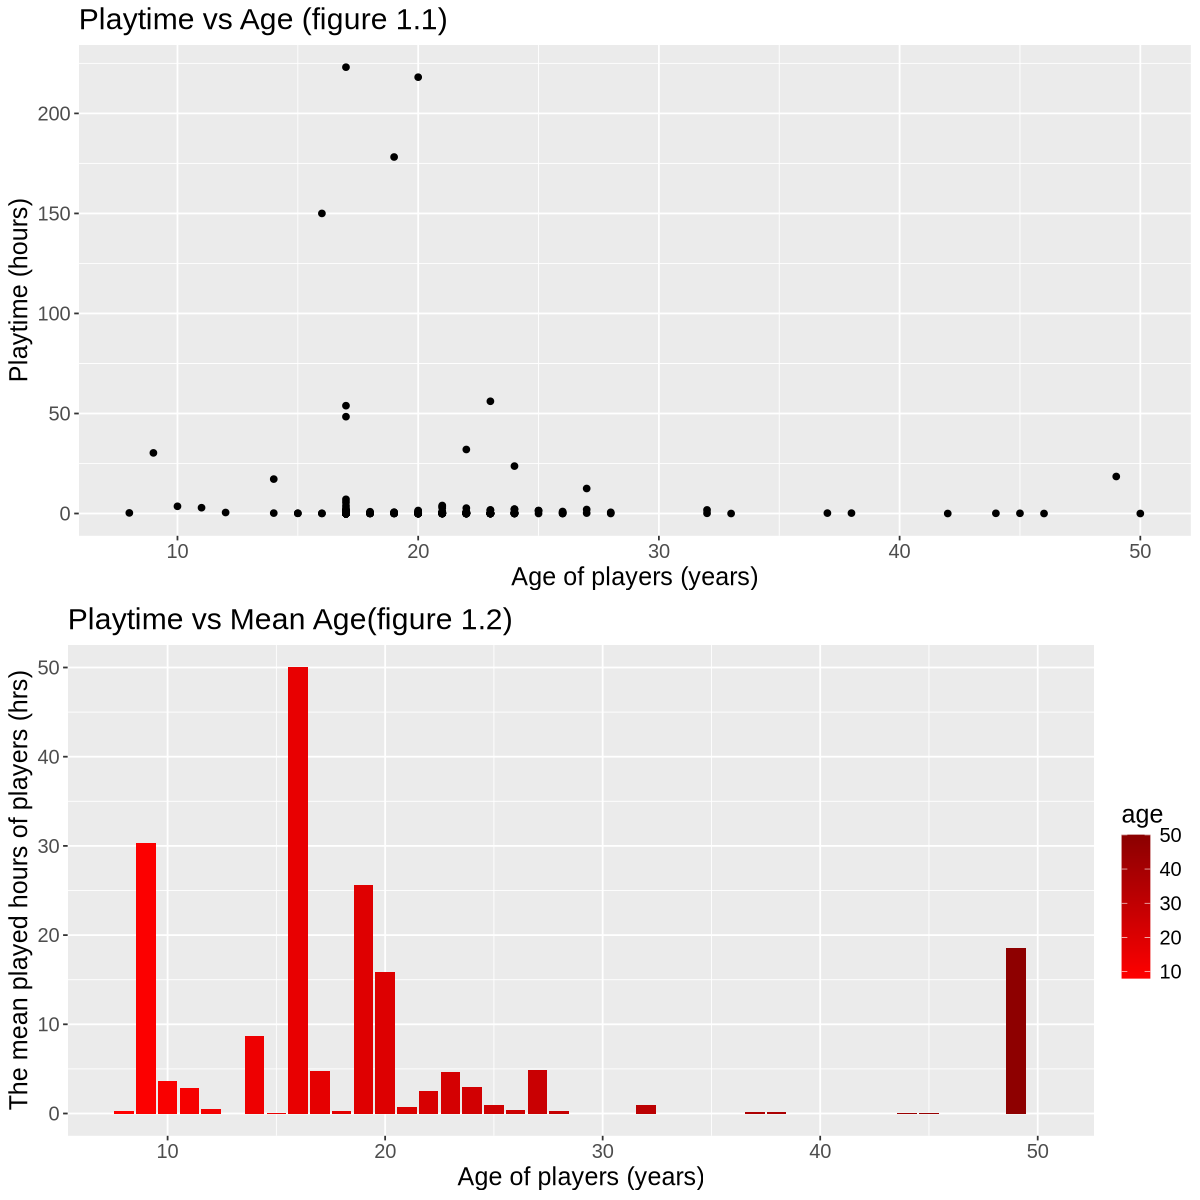

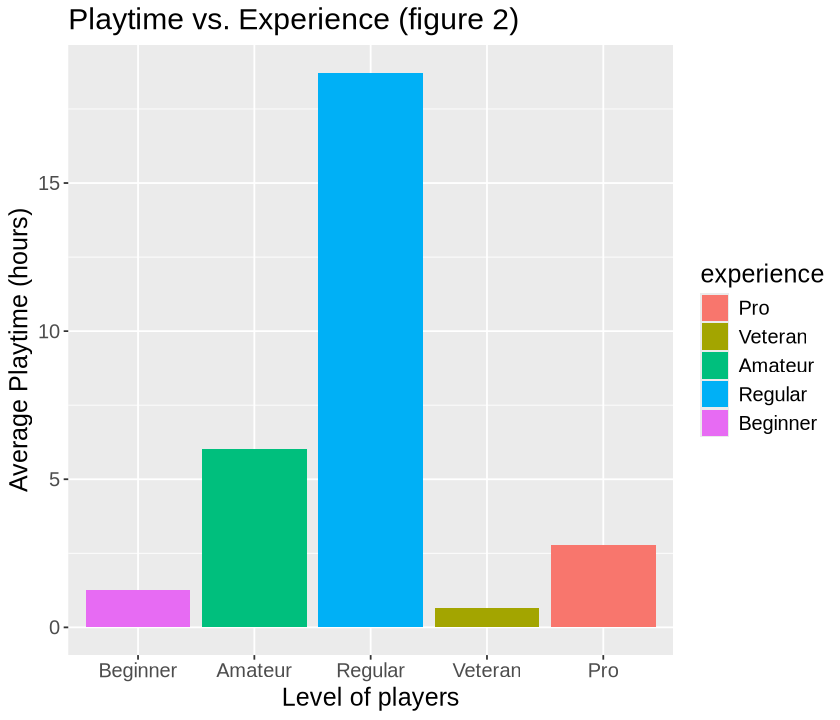

subscribe,avg_playtime
<lgl>,<dbl>
FALSE,0.5019231
TRUE,7.8830986


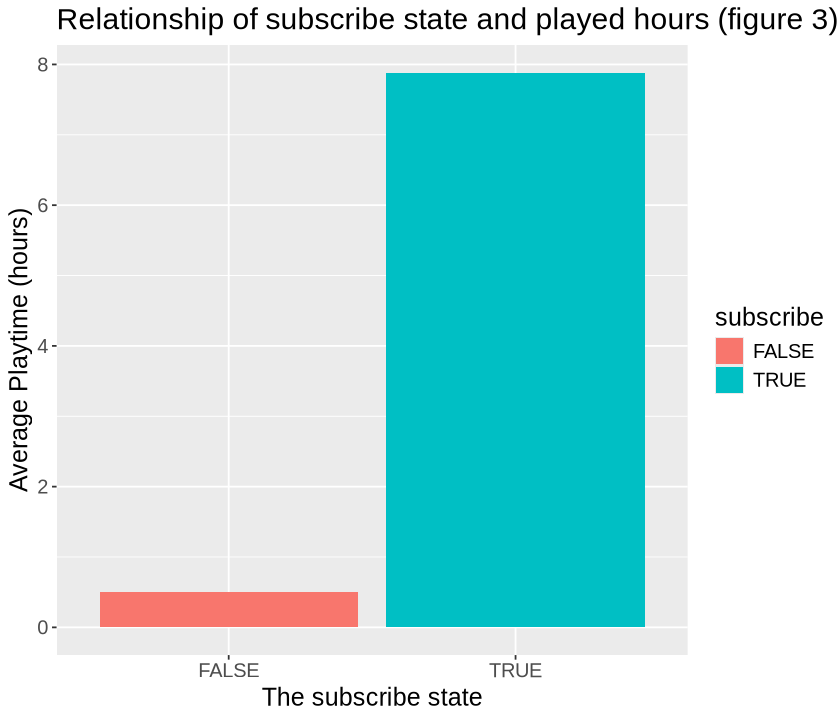

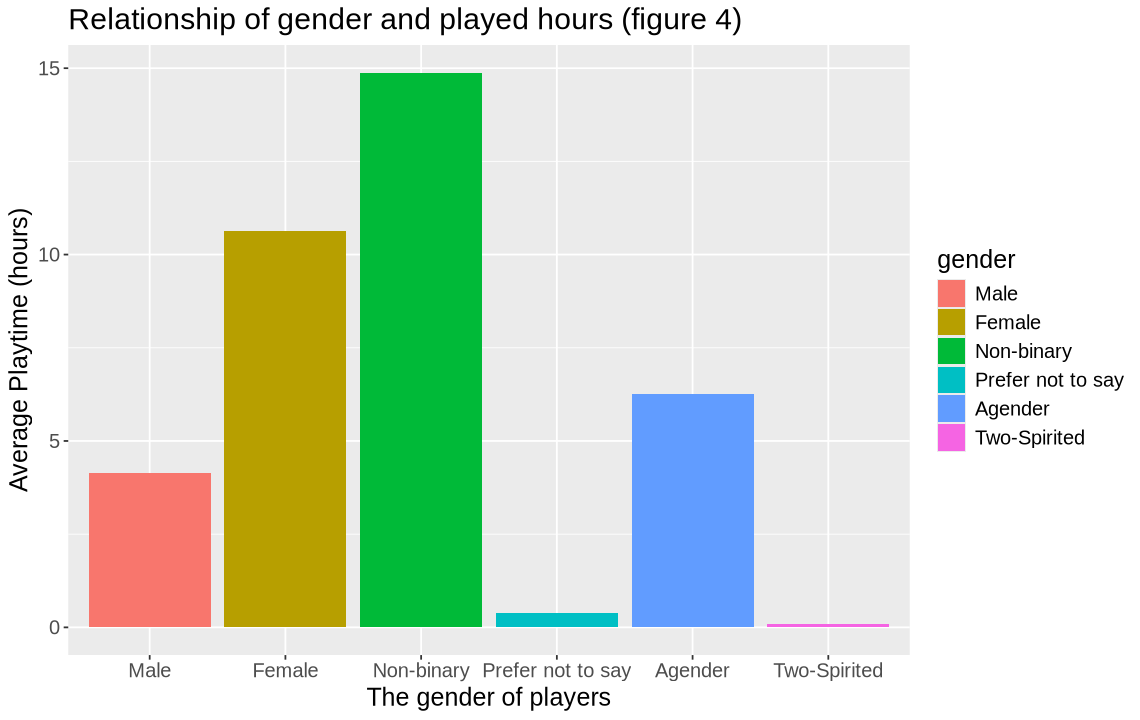

In [6]:
# Creating a scatterplot 
age_vs_playtime_with_experience <- player_data_tidy |>
        ggplot(aes(x = age, y = played_hours)) +
       scale_color_gradient(low = "red",  high = "darkred")+
        geom_point() + 
        labs(x = "Age of players (years)", y = "Playtime (hours)", title = "Playtime vs Age (figure 1.1)")+
        theme(text = element_text(size = 15))

# Creating a bar graph for mean played hours by age
Age_ph_hist_line_plot <- player_data_tidy|>
    group_by(age)|> 
     summarize(avg_playtime = mean(played_hours))|>  # Get the average time of play for each Age
    ggplot(aes(x = age, y = avg_playtime, fill = age)) +
       scale_fill_gradient(low = "red",  high = "darkred")+
       geom_bar(stat = "identity")+
       xlab("Age of players (years)") +
       ylab("The mean played hours of players (hrs)") +
        labs(title = "Playtime vs Mean Age(figure 1.2)")+
       theme(text = element_text(size = 15))

options(repr.plot.width = 10, repr.plot.height = 10) 
plot_grid(age_vs_playtime_with_experience, Age_ph_hist_line_plot, ncol = 1)

# Creating a bar graph for mean played hours by experience
options(repr.plot.width = 7, repr.plot.height = 6) 
age_vs_playtime_with_experience <- player_data_tidy |>
        group_by(experience)|> 
        summarize(avg_playtime = mean(played_hours))|> # Get the average time of play for each Age
        ggplot(aes(x = experience, y = avg_playtime, fill = experience)) +
        geom_bar(stat = "identity", ) + 
        scale_x_discrete(limits = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"))+  # Arrange the level of players
        labs(x = "Level of players", y = "Average Playtime (hours)", title = "Playtime vs. Experience (figure 2)")+
        theme(text = element_text(size = 15))
age_vs_playtime_with_experience

# Creating a bar graph for mean played hours by subscribe
subs_ph_bar_mean <- player_data_tidy|>
    group_by(subscribe)|> 
    summarize(avg_playtime = mean(played_hours))

subs_ph_bar_plot <- subs_ph_bar_mean|>  # Get the average time based on if they subscribe the game-related news
    ggplot(aes(x = subscribe, 
               y = avg_playtime, 
               fill = subscribe)) + 
       geom_bar(stat = "identity")+
       xlab("The subscribe state") +
       ylab("Average Playtime (hours)") +
       labs(fill = "subscribe")+
       ggtitle("Relationship of subscribe state and played hours (figure 3)")+
       theme(text = element_text(size = 15))
subs_ph_bar_plot
subs_ph_bar_mean

# Creating a bar graph for mean played hours by gender
gen_ph_bar_mean <- player_data_tidy|>
    group_by(gender)|> 
    summarize(avg_playtime = mean(played_hours))

gen_ph_bar_plot <- gen_ph_bar_mean|>  # Get the average time based on if they subscribe the game-related news
    ggplot(aes(x = gender, 
               y = avg_playtime, 
               fill = gender)) + 
       geom_bar(stat = "identity")+
       xlab("The gender of players") +
       ylab("Average Playtime (hours)") +
       labs(fill = "gender")+
       ggtitle("Relationship of gender and played hours (figure 4)")+
       theme(text = element_text(size = 15))
options(repr.plot.width = 9.5, repr.plot.height = 6) 
gen_ph_bar_plot

#### Figure 1 Analysis:


- From the “Playtime vs. Age” graph, we can see that there isn’t really any linear correlation we can observe. If we were to outline the shape of the distribution, we can see that the distribution is right-skewed (long right tail) with its peak around the 17-18 year old age mark, implying that the older the players are the lower their overall playtime.

- From the “Playtime vs mean Age (distributions)” we can see that the hours of play peaks at around age 18 and then drops off significantly after age 20. This could be indicative of many things: a change of lifestyle, less interest in gaming, and more.

- This lack of a linear correlation and along with the relatively small size of the data leads us to utilise the KNN regression model as a method most appropriate to answer our question of predicting played_hours.


#### Figure 2 Analysis:

- From the “Playtime vs. Experience" graph, we can observe that amateurs and regulars have a much higher average playtime than veterans, pros, and beginners.

- This is somewhat expected as with someone with prior experience playing/beating the game (multiple times), playing the game would become a lot more repetitive and as a consequence, more boring, making them less inclined to play the game. 

#### Figure 3 Analysis:




- From the “Relationship of Subscribe State and Played Hours” graph, we can see that a player being subscribed or not generally has a strong influence on the average playtime of participants. For players subscribed to the newsletter, the mean playtime was 7.8830986 hours and for players not subscribed to the newsletter, the mean playtime was 0.5019231 hours. 

#### Figure 4 Analysis:

- From the “Relationship of gender and played hours” graph, there are significant differences in the average playtime of different gender groups.
    - "Non-binary" group has the highest average playing time, which is close to or over 15 hours;
    - The average playtime of "Prefer not to say" and "Female" is also relatively high, being around 10 to 12 hours;
    - "Male" is relatively low, around 4 hours;
    - "Agender" and "Two-spirited" had the lowest average playtime, which was just under one hour.

This demonstrates that players who identify as different genders do differ in their average playing time, which may be a useful predictor.

### Data Analysis
To analyze our data, we decided to train a KNN-Regression model. Our reasoning for this is that we are attempting to predict a numerical value, which necessitates the use of either linear regression or KNN-Regression. From our visualization, we did not see a clear linear relationship. Additionally, the dataset is not that large, with only 194 observations, which is good for KNN-Regressions. 

To train our model, we first split our dataset into a test set and a train set. We decided to use a 75-25 train-test split for our model.

In [7]:
# Splitting data into train and test
players_split <- initial_split(player_data_dummy, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

Next, we created our recipe and model. Due to KNN-Regression calculating error from euclidean distance, scaling and centering is necessary to prevent variables with larger ranges contributing more to the distance calculation and over-influencing the prediction. 

In [8]:
# Creating recipe and spec
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

players_recipe <- recipe(played_hours ~ ., data = player_data_dummy) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())


Afterwards, we trained our model on k values from 1 to 100. We utilized 5-fold cross validation to provide a better estimate of model accuracy. Then, we collected the metrics for each k value.

In [9]:
players_vfold = vfold_cv(players_training, v = 5, strata = played_hours)
players_workflow <- workflow() |>
        add_recipe(players_recipe) |>
        add_model(players_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

players_results <- players_workflow |>
        tune_grid(resamples = players_vfold, grid = gridvals) |>
        collect_metrics()

players_results

→ A | warning: !  The following column has zero variance so scaling cannot be used: agender.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,40.504940693,5,9.2590472327,Preprocessor1_Model001
1,rsq,standard,0.003661718,5,0.0004505061,Preprocessor1_Model001
2,rmse,standard,34.192008775,5,7.5815420461,Preprocessor1_Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,rsq,standard,0.06311706,5,0.02605157,Preprocessor1_Model099
100,rmse,standard,27.31597852,5,8.36739403,Preprocessor1_Model100
100,rsq,standard,0.06261832,5,0.02507421,Preprocessor1_Model100


We found the k-val with the lowest RMSE value next, which turned out to be 6.

In [10]:
players_rmse <- players_results |>
        filter(.metric == "rmse") 

players_min <- players_rmse |> 
        slice_min(std_err)
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,rmse,standard,30.39263,5,6.746096,Preprocessor1_Model006


To get a better sense of how our model performed across different k-vals, we decided to graph k-val vs RMSE.

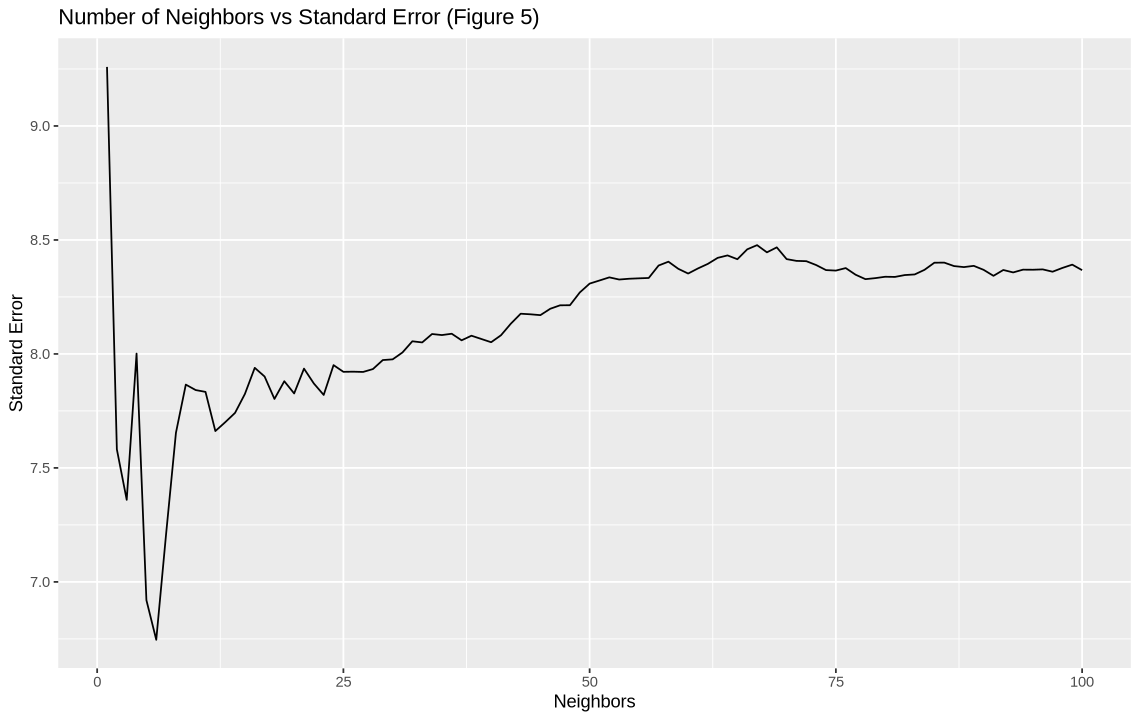

In [11]:
players_rmse |> 
    ggplot(aes(x = neighbors, y = std_err)) +
    geom_line() +
    labs(x = "Neighbors", y = "Standard Error", title = "Number of Neighbors vs Standard Error (Figure 5)")

Continuing, we decided to make a prediction on our test set. We did this using the k-val with the minimum RMSE we got from previous steps. After making the prediction, we look at the metrics again to see our RMSPE value.

In [12]:
k_min <- players_min |>
         pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

players_best_fit <- workflow() |>
         add_recipe(players_recipe) |>
         add_model(players_best_spec) |>
         fit(data = players_training)

players_preds <- players_best_fit |>
          predict(players_testing) |>
          bind_cols(players_testing) 

players_summary <- players_preds |>
          metrics(truth = played_hours, estimate = .pred)

players_summary


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.541500e+01
rsq,standard,2.266247e-04
mae,standard,7.135714e+00


Finally, we plotted the predicted time against the age of the participants to get a sense of what the prediction line may look like. Note that due to our KNN-Regression model using many predictor variables, it is difficult to visualize what the prediction line actually looks like. 

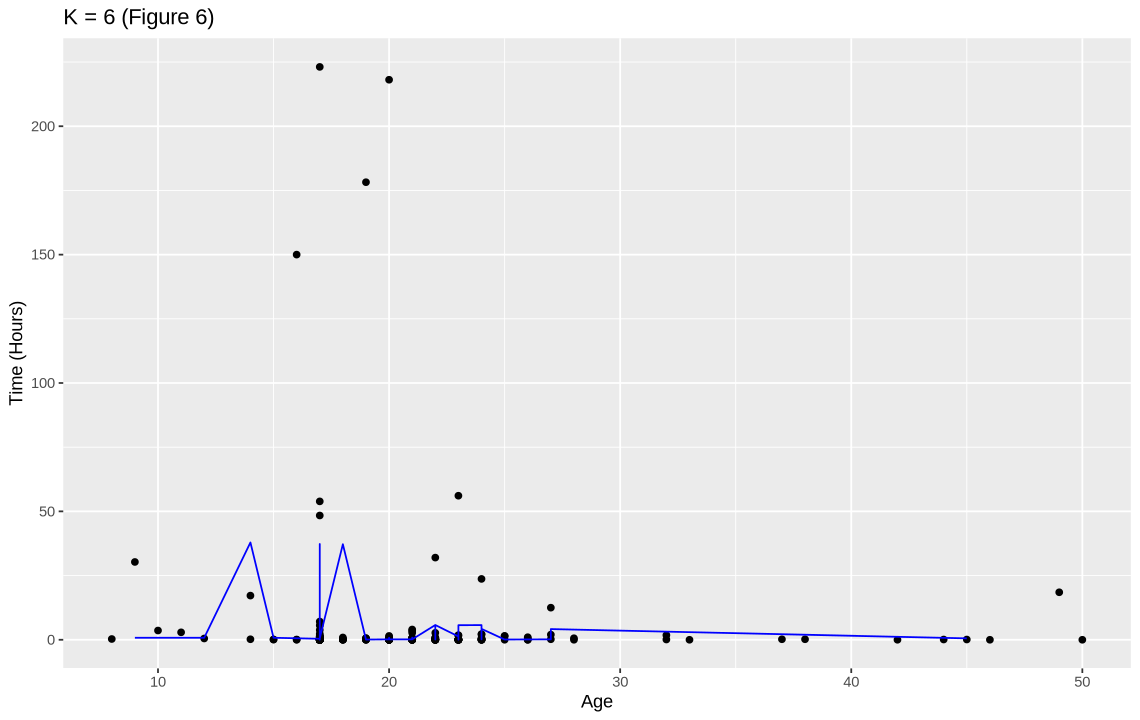

In [13]:
players_plot <- ggplot(player_data_dummy, aes(x = age, y = played_hours)) + 
        geom_point() + 
        geom_line(data = players_preds,
                 mapping = aes(x = age, y = .pred),
                 color = "blue") +
        labs(x = "Age", y = "Time (Hours)") + 
        ggtitle("K = 6 (Figure 6)")

players_plot

From our visualization, we can see that the predictions don't seem to follow the points very well. Furthermore, our RMSE was 6.75, while our RMSPE was 15.41, meaning that our model did not succeed in predicting played_hours from experience, age, subscribe, and gender by our standards.

## Discussion

### Summary of Findings
Based on our visual analysis, we believed that the variables subscription status, experience, gender, and age could have an impact on prediction results, and we  used them as predictors to build a KNN regression model. However, the model's performance did not meet expectations, with a Root Mean Squared Prediction Error (RMSPE) of 15.41 compared to a RMSE value of 6.75. Therefore, we found that it is not possible to create a KNN-Regression model that used the variables experience, age, subscribe, and gender to predict played_hours in players.csv such that the RMSPE is no larger than 1.3 times the RMSE.


### Reflection of Findings
These findings ran contrary to what we were expecting, but we propose the following reasons as to why the model did not perform to our expectations. 
Firstly, this error may stem from sample size insufficiency, seeing as there were only 194 observations. In addition, from our summary of the data, we realized there was a disproportionate amount of certain categories in our factor variables compared to others (124 Male vs 2 Agender and 63 Amateurs vs 13 Pros), which could have led to poor predictions for the less represented categories. Also, by using normalization, we assume that all variables are equally important, when in reality this is most likely not the case. Another possible issue for the model could be outliers interfering with the predictions, such as the 4 players that played nearly 25 - 30 times as much as the average player. To optimize the model in the future, multiple options are possible. First, expand the data scale to increase sample size and diversity, ensuring sufficient, proportionate data; second, re-evaluate the effectiveness of each variable as a predictor to avoid interference with prediction results; and finally, detect and adjust outliers to reduce noise interference.


### Impacts of Findings

Despite our findings not having much direct use for the researchers running PLAICraft due to the lack of success in our model, it may allow future researchers to understand what is necessary to create a successful model. I believe that our findings highlight the necessity of 2 important things when it comes to creating a KNN-Regression, which are sufficient size of data, and having proportionate data. As a result, a successful model could be developed in the future. 


### Future Questions

Some future questions that come to mind from this project are:
- Are certain variables more important than others when it comes to predicting hours played?
- If certain variables are more important, which variables are most important in terms of predicting hours played?
- Can you predict a player's willingness to buy a game from the same predictors (age, gender, experience, subscribe)?

